### candidate tournament

In [ ]:
import random
from typing import Dict, List, Tuple
from pydantic import BaseModel, Field
import os
from functions import text_extraction
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


root = "/".join(os.getcwd().split("/")[:-1])
resumes_path = os.path.join(root, 'data', "raw", "cv")
resumes_list = os.listdir(resumes_path)

load_dotenv()

llm = ChatOpenAI(
    model = "gpt-4o-2024-08-06"
)

candidates_dict = {
    file.split("-")[0] : text_extraction(os.path.join(resumes_path, file)) for file in resumes_list
}

job_description = text_extraction(
    file_path = "/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/raw/job/data_role_des.txt"
)

class GroupWinners(BaseModel):
    winner_ids: List[str] = Field(..., description="A list of 1 or 2 IDs of the best candidates in the group.")

selection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert recruiter conducting a tournament selection round. "
            "Analyze the provided resumes and select the ONE to TWO best candidates "
            "who are most qualified for the role described below. Your output must ONLY be the IDs of the winners."
        ),
    ),
    (
        "human",
        (
            "Based on the **Job Description** provided, select the best 1 or 2 winners "
            "from the candidates with the following IDs: {all_candidate_ids}."
            "\n\n**Job Description:**\n{job_description}" 
            "\n\n**Candidate Resumes:**\n{group_resumes}"
        ),
    ),
])

def tournament_evaluation(
    candidates_dict : dict,
    job_description : str,
    final_target : int = 4,
    group_size : int = 5,
    
):
    llm_selector = llm.with_structured_output(schema = GroupWinners)
    selection_chain = selection_prompt | llm_selector
    candidates_to_evaluate = candidates_dict
    
    while len(candidates_to_evaluate) > final_target:
        candidate_ids = list(candidates_to_evaluate.keys())
        random.shuffle(candidate_ids)
        winners_of_round = {}
        groups = [
            candidate_ids[i : i + group_size] for i in range(0, len(candidate_ids), group_size)
        ]
        for group_index, group_ids in enumerate(groups):
            group_resumes_string = '\n---\n'.join([
                f"Candidate ID: {cid}\nResume: {candidates_to_evaluate[cid]}" for cid in group_ids
            ])
            try:
                selection_obj = selection_chain.invoke({
                    "group_resumes" : group_resumes_string,
                    "all_candidate_ids" : ', '.join(group_ids),
                    "job_description" : job_description
                })
                for winner_id in selection_obj.winner_ids:
                    if winner_id in group_ids:
                        winners_of_round[winner_id] = candidates_to_evaluate[winner_id]
            except Exception as e:
                print(f"Error evaluating group {group_index + 1}: {e}")
                if group_ids:
                    winners_of_round[group_ids[0]] = candidates_to_evaluate[group_ids[0]]
        candidates_to_evaluate = winners_of_round
        print(f"Round finished. {len(candidates_to_evaluate)} candidates promoted")
    
    return candidates_to_evaluate

final_selection = tournament_evaluation(
    candidates_dict = candidates_dict,
    job_description = job_description
)
    

Round finished. 9 candidates promoted
Round finished. 4 candidates promoted


In [14]:
final_selection

{'90e485656ce9236d': 'Innovative and growth-driven Data Analyst with over 2 years of experience designing and delivering end-to-end data analytics and data science solutions across cloud platforms. Adept at building and monitoring secure, scalable data pipelines and transforming raw data into actionable insights that improve business performance. Proficient in SQL, Python, R, and data visualization tools like Power BI and Tableau, with hands-on experience using dbt, Databricks, BigQuery, and Snowflake. Strong foundational understanding of machine learning models and their integration within business intelligence platforms. Demonstrated ability to collaborate across cross-functional teams—including engineers, data scientists, and stakeholders—to support data-driven decision-making and ensure data integrity and governance. Excellent communicator, known for turning complex data into clear narratives that support strategic innovation and growth.\nProjects\nRetail Sales Analysis | SQL & Pow

### adding an explanation to the selection

In [1]:
import random
from typing import Dict, List, Tuple
from pydantic import BaseModel, Field
import os
from functions import text_extraction
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

load_dotenv()

root = "/".join(os.getcwd().split("/")[:-1])
resumes_path = os.path.join(root, 'data', "raw", "cv")
resumes_list = os.listdir(resumes_path)

llm = ChatOpenAI(
    model = "gpt-4o-2024-08-06"
)

candidates_dict = {
    file.split("-")[0] : text_extraction(os.path.join(resumes_path, file)) for file in resumes_list
}

job_description = text_extraction(
    file_path = "/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/raw/job/data_role_des.txt"
)


class WinnerRationale(BaseModel):
    """Details for a single selected candidate."""
    candidate_id: str = Field(..., description="The unique ID of the selected winner.")
    justification: str = Field(..., description="A 1-2 sentence explanation citing specific evidence from the resume that qualifies this candidate over the others.")

class GroupWinners(BaseModel):
    """The structured output containing all selected winners and their rationale."""
    selected_winners: List[WinnerRationale] = Field(..., description="A list of 1 or 2 candidates selected as the best in the group, each with a justification.")
    # You can also add a field for an overall comparison summary if helpful
    overall_summary: str = Field(..., description="A brief summary of the key difference between the winners and the rest of the group.")

selection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert recruiter conducting a tournament selection round. "
            "Analyze the provided resumes and select the ONE to TWO best candidates who are most qualified for the role. "
            "For each winner, you **MUST** provide a concise justification (1-2 sentences) that highlights the most relevant skills/experience "
            "from their resume compared to the other candidates in the group. Your output must strictly follow the required JSON schema."
        ),
    ),
    (
        "human",
        (
            "Based on the **Job Description** provided, select the best 1 or 2 winners "
            "from the candidates with the following IDs: {all_candidate_ids}."
            "\n\n**Job Description:**\n{job_description}" 
            "\n\n**Candidate Resumes:**\n{group_resumes}"
        ),
    ),
])

def tournament_evaluation(
    candidates_dict : dict,
    job_description : str,
    final_target : int = 2,
    group_size : int = 5,
    
):
    llm_selector = llm.with_structured_output(schema = GroupWinners)
    selection_chain = selection_prompt | llm_selector
    candidates_to_evaluate = candidates_dict
    
    while len(candidates_to_evaluate) > final_target:
        candidate_ids = list(candidates_to_evaluate.keys())
        random.shuffle(candidate_ids)
        winners_of_round = {}
        groups = [
            candidate_ids[i : i + group_size] for i in range(0, len(candidate_ids), group_size)
        ]
        for group_index, group_ids in enumerate(groups):
            group_resumes_string = '\n---\n'.join([
                f"Candidate ID: {cid}\nResume: {candidates_to_evaluate[cid]}" for cid in group_ids
            ])
            try:
                # selection_obj is now an instance of the new GroupWinners class
                selection_obj = selection_chain.invoke({
                    "group_resumes": group_resumes_string,
                    "all_candidate_ids": ", ".join(group_ids),
                    "job_description": job_description
                })
                print("-"*20)
                print(f"Overall summary: {selection_obj.overall_summary}")
                print("-"*20)
                # Iterate through the structured list of winners and rationales
                for winner_data in selection_obj.selected_winners:
                    winner_id = winner_data.candidate_id
                    
                    if winner_id in group_ids:
                        # You'll need a way to store the rationale. Let's assume a new state field:
                        # state.round_rationales[round_number][winner_id] = winner_data.justification
                        
                        # For simplicity in this example, we just promote the winner
                        winners_of_round[winner_id] = candidates_to_evaluate[winner_id] 
                        
                        print(f"Candidate {winner_id} promoted. Reason: {winner_data.justification}")

            except Exception as e:
                print(f"Error evaluating group {group_index + 1}: {e}")
                if group_ids:
                    winners_of_round[group_ids[0]] = candidates_to_evaluate[group_ids[0]]
        candidates_to_evaluate = winners_of_round
        print(f"Round finished. {len(candidates_to_evaluate)} candidates promoted")
    
    return candidates_to_evaluate

final_selection = tournament_evaluation(
    candidates_dict = candidates_dict,
    job_description = job_description
)


--------------------
Overall summary: Priya Singh and Sairaj Suryavanshi are the best candidates due to their strong backgrounds in ETL processes, SQL, and data visualization, which are critical for providing innovative data-driven solutions as outlined in the job description.
--------------------
Candidate e5f8984dfa4cae3b promoted. Reason: Priya Singh stands out with her strong experience in ETL processes, SQL proficiency, and business intelligence reporting through Celonis, directly aligning with the job's data analytics and solution delivery focus.
Candidate a8ca1108dd06b907 promoted. Reason: Sairaj Suryavanshi is well-suited for the role with extensive experience in SQL, ETL processes, and data visualization using Power BI, combined with a proactive consulting background, meeting the key requirements of the job description.
--------------------
Overall summary: Abhishek Sarda and Sahil Dwivedi stand out due to their strong technical backgrounds in data science and experience with 

### providing the evaluation criteria instead of the full job description

In [2]:
selection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert recruiter conducting a tournament selection round. "
            "Analyze the provided resumes and select the ONE to TWO best candidates who are most qualified based **ONLY** on the required skills listed below. "
            "For each winner, you MUST provide a concise justification (1-2 sentences) that highlights the comparative advantages of choosing that candidate instead of another "
            "from their resume compared to the other candidates in the group. Your output must strictly follow the required JSON schema."
        ),
    ),
    (
        "human",
        (
            "Based on the **REQUIRED EVALUATION CRITERIA** provided, select the best 1 or 2 winners "
            "from the candidates with the following IDs: {all_candidate_ids}."
            "\n\n**REQUIRED EVALUATION CRITERIA:**\n{combined_criteria_list}"
            "\n\n**Candidate Resumes:**\n{group_resumes}"
        ),
    ),
])

def tournament_evaluation(
    candidates_dict : dict,
    job_criteria_list : list,
    final_target : int = 2,
    group_size : int = 5,
    
):
    candidates_to_evaluate = candidates_dict
    llm_selector = llm.with_structured_output(schema = GroupWinners)
    selection_chain = selection_prompt | llm_selector
    all_criteria = "\n- ".join(job_criteria_list)
    # Store initial group assignments
    initial_groups = {}
    round_number = 0
    
    while len(candidates_to_evaluate) > final_target:
        candidate_ids = list(candidates_to_evaluate.keys())
        random.shuffle(candidate_ids)
        winners_of_round = {}
        groups = [
            candidate_ids[i : i + group_size] for i in range(0, len(candidate_ids), group_size)
        ]
        for group_index, group_ids in enumerate(groups):
            # Store initial group assignments
            if round_number == 0:
                initial_groups[group_index] = group_ids
            
            group_resumes_string = '\n---\n'.join([
                f"Candidate ID: {cid}\nResume: {candidates_to_evaluate[cid]}" for cid in group_ids
            ])
            try:
                # selection_obj is now an instance of the new GroupWinners class
                selection_obj = selection_chain.invoke({
                    "group_resumes": group_resumes_string,
                    "all_candidate_ids": ", ".join(group_ids),
                    "combined_criteria_list": all_criteria # <--- PASS THE CRITERIA
                })
                print("-"*20)
                print(f"Overall summary: {selection_obj.overall_summary}")
                print("-"*20)
                # Iterate through the structured list of winners and rationales
                for winner_data in selection_obj.selected_winners:
                    winner_id = winner_data.candidate_id
                    
                    if winner_id in group_ids:
                        # You'll need a way to store the rationale. Let's assume a new state field:
                        # state.round_rationales[round_number][winner_id] = winner_data.justification
                        
                        # For simplicity in this example, we just promote the winner
                        winners_of_round[winner_id] = candidates_to_evaluate[winner_id] 
                        
                        print(f"Candidate {winner_id} promoted. Reason: {winner_data.justification}")

            except Exception as e:
                print(f"Error evaluating group {group_index + 1}: {e}")
                if group_ids:
                    winners_of_round[group_ids[0]] = candidates_to_evaluate[group_ids[0]]

        round_number += 1
        candidates_to_evaluate = winners_of_round
        print(f"Round finished. {len(candidates_to_evaluate)} candidates promoted")
    
    return candidates_to_evaluate, initial_groups

final_selection, initial_groups = tournament_evaluation(
    candidates_dict = candidates_dict,
    job_criteria_list = ['Data Analytics', "Business Transformation", "Information Technology", "Cloud Computing", "Data Governance","SQL","ETL/ELT Processes","Data Visualization Tools","Data Transformation Tools", "Data Modeling"]
)
     

--------------------
Overall summary: Sairaj Suryavanshi and Abhishek Sarda were selected as the best candidates due to their direct experience and proficiency in ETL/ELT processes, data modeling, SQL, and data analytics, as well as their proven ability to leverage advanced data transformation and visualization tools.
--------------------
Candidate a8ca1108dd06b907 promoted. Reason: Sairaj Suryavanshi is highly qualified with extensive experience in ETL, data modeling, and visualization using PowerBI, combined with a Master's in Data Science focusing on statistical analysis and business-driven solutions, directly aligning with the required skills.
Candidate b5142b9b9676a4f9 promoted. Reason: Abhishek Sarda boasts strong expertise in ETL, data modeling, SQL, and cloud computing with Azure, and demonstrates a comprehensive application of advanced analytics through projects that enhance business decision-making, perfectly fitting the criteria.
--------------------
Overall summary: Eric Zh

In [3]:
final_selection

{'0176a86af53206ae': 'Sahil Dwivedi\nData Analyst\nMelbourne, Vic | +61- 040 220 9556 | sahild091999@gmail.com | LinkedIn\nSUMMARY\nExperienced Data Analyst with over 3 years of hands-on experience in data analysis, predictive modeling, and business\nintelligence. Skilled in using tools such as Python, SQL, Power BI, Tableau, and Excel to collect, clean, transform, and visualize\nlarge datasets, enabling data-driven decision-making across business functions. Proficient in developing ETL pipelines,\nforecasting models, and interactive dashboards to optimize inventory, identify trends, and improve operational efficiency. Adept\nat statistical analysis, machine learning, and data storytelling to communicate insights to both technical and non-technical\nstakeholders. Strong team collaborator with a proven ability to work cross-functionally in agile environments, solve complex\nproblems, and deliver impactful analytical solutions. Passionate about leveraging data to drive strategic decision

In [4]:
initial_groups

{0: ['a8ca1108dd06b907',
  '934d1fdb8a6d1063',
  '493d0d19e0150412',
  'b5142b9b9676a4f9',
  'c5f45dfe145427e1'],
 1: ['adbef5e743bf5c48',
  'f476ce0793a219b1',
  '6d743d56d9692fd0',
  '4a9374ec3b2ca204',
  '1f04921d492de215'],
 2: ['ccfed7e7060c9916',
  '0176a86af53206ae',
  'e5f8984dfa4cae3b',
  'c9cddf5fb828eab6',
  'c69f2087775fc760'],
 3: ['f2ca85739fda42e4',
  '8821085d3ae9e0ce',
  'dd417e3f63181d20',
  '77aacb560b1dd217',
  'de4e24b044e42f42'],
 4: ['af62b86c3a326086',
  '2b4c705e8b2a0770',
  '8ed9c5e84fb32c65',
  '6700f96c37c87933',
  '90e485656ce9236d'],
 5: ['fae54469e0d024e8']}

### incorporating that tournament into a graph

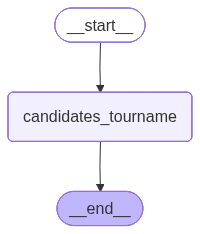

In [24]:
import random
random.seed(2000)
from typing import Dict, List, Optional
from pydantic import BaseModel, Field
import os
from functions import text_extraction
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display
from collections import defaultdict

# environment variables
load_dotenv()
# folder paths
root = "/".join(os.getcwd().split("/")[:-1])
resumes_path = os.path.join(root, 'data', "raw", "cv")
resumes_list = os.listdir(resumes_path)
# llm
llm = ChatOpenAI(
    model = "gpt-4o-2024-08-06"
)
# candidates dictionary with id : resume pairs
candidates_dict = {
    file.split("-")[0] : text_extraction(os.path.join(resumes_path, file)) for file in resumes_list
}
# string with the job description
job_description = text_extraction(
    file_path = "/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/raw/job/data_role_des.txt"
)
# prompt for selection
selection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert recruiter conducting a tournament selection round. "
            "Analyze the provided resumes and select the ONE to TWO best candidates who are most qualified based **ONLY** on the required skills listed below. "
            "For each winner, you MUST provide a concise justification (1-2 sentences) that highlights the comparative advantages of choosing that candidate instead of another "
            "from their resume compared to the other candidates in the group. Your output must strictly follow the required JSON schema."
        ),
    ),
    (
        "human",
        (
            "Based on the **REQUIRED EVALUATION CRITERIA** provided, select the best 1 or 2 winners "
            "from the candidates with the following IDs: {all_candidate_ids}."
            "\n\n**REQUIRED EVALUATION CRITERIA:**\n{combined_criteria_list}"
            "\n\n**Candidate Resumes:**\n{group_resumes}"
        ),
    ),
])
# schema for structure output
class WinnerRationale(BaseModel):
    """Details for a single selected candidate."""
    candidate_id: str = Field(..., description="The unique ID of the selected winner.")
    justification: str = Field(..., description="A 1-2 sentence explanation citing specific evidence from the resume that qualifies this candidate over the others.")

class GroupWinners(BaseModel):
    """The structured output containing all selected winners and their rationale."""
    selected_winners: List[WinnerRationale] = Field(..., description="A list of 1 or 2 candidates selected as the best in the group, each with a justification.")
    # You can also add a field for an overall comparison summary if helpful
    overall_summary: str = Field(..., description="A brief summary of the key difference between the winners and the rest of the group.")

class SampleState(BaseModel):
    candidates_dict : Optional[Dict[str, str]]
    job_description : Optional[str]
    job_criteria : Optional[List[str]]
    batch_size : Optional[int] = 5
    top_candidates_num : Optional[int] = 3
    # store the top candidates
    top_candidates_dict : Optional[Dict] = {}
    # initial groups of candidates
    initial_tournament_groups : Optional[Dict] = {}
    # overall summary per round
    round_summaries : Optional[Dict] = {}
    # rationale for the selected candidates
    round_rationales : Optional[Dict] = {}
    
    
# unique node
def candidates_tourname(state : SampleState) ->SampleState:
    candidates_to_evaluate = state.candidates_dict
    all_criteria = ', '.join(state.job_criteria)
    llm_selector = llm.with_structured_output(schema = GroupWinners)
    selection_chain = selection_prompt | llm_selector
    # Store initial group assignments
    initial_groups = defaultdict(dict)
    round_number = 0
    round_summaries = defaultdict(dict)
    round_rationales = defaultdict(dict)
    while len(candidates_to_evaluate) > state.top_candidates_num:
        candidate_ids = list(candidates_to_evaluate.keys())
        random.shuffle(candidate_ids)
        winners_of_round = {}
        groups = [
            candidate_ids[i : i + state.batch_size] for i in range(0, len(candidate_ids), state.batch_size)
        ]
        for group_index, group_ids in enumerate(groups):
            # Store initial group assignments
            if round_number == 0:
                initial_groups[group_index] = group_ids
            
            group_resumes_string = '\n---\n'.join([
                f"Candidate ID: {cid}\nResume: {candidates_to_evaluate[cid]}" for cid in group_ids
            ])
            try:
                # selection_obj is now an instance of the new GroupWinners class
                selection_obj = selection_chain.invoke({
                    "group_resumes": group_resumes_string,
                    "all_candidate_ids": ", ".join(group_ids),
                    "combined_criteria_list": all_criteria # <--- PASS THE CRITERIA
                })
                print("-"*20)
                print(f"Overall summary: {selection_obj.overall_summary}")
                print("-"*20)
                round_summaries[round_number][group_index] = selection_obj.overall_summary
                # state.round_summaries[round_number][group_index] = selection_obj.overall_summary
                # Iterate through the structured list of winners and rationales
                for winner_data in selection_obj.selected_winners:
                    winner_id = winner_data.candidate_id
                    
                    if winner_id in group_ids:
                        # You'll need a way to store the rationale. Let's assume a new state field:
                        # state.round_rationales[round_number][winner_id] = winner_data.justification
                        
                        # For simplicity in this example, we just promote the winner
                        winners_of_round[winner_id] = candidates_to_evaluate[winner_id] 
                        
                        print(f"Candidate {winner_id} promoted. Reason: {winner_data.justification}")

            except Exception as e:
                print(f"Error evaluating group {group_index + 1}: {e}")
                if group_ids:
                    winners_of_round[group_ids[0]] = candidates_to_evaluate[group_ids[0]]

        round_number += 1
        candidates_to_evaluate = winners_of_round
        print(f"Round finished. {len(candidates_to_evaluate)} candidates promoted")
    state.top_candidates_dict = candidates_to_evaluate
    state.initial_tournament_groups = initial_groups
    state.round_summaries = round_summaries
    return state

# simple graph
simple_graph = StateGraph(SampleState)
simple_graph.add_node("candidates_tourname", candidates_tourname)
simple_graph.add_edge(START, "candidates_tourname")
simple_graph.add_edge("candidates_tourname", END)
compiled_graph = simple_graph.compile()

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [25]:
sample_input = SampleState(
    candidates_dict = candidates_dict,
    job_description = job_description,
    job_criteria = ['Data Analytics', "Business Transformation", "Information Technology", "Cloud Computing", "Data Governance","SQL","ETL/ELT Processes","Data Visualization Tools","Data Transformation Tools", "Data Modeling"],
    batch_size = 5,
    top_candidates_num = 3
)
results = compiled_graph.invoke(
    input = sample_input
)

--------------------
Overall summary: Both Sahil Dwivedi and Abhishek Sarda provide a strong match to all required skills, showcasing significant practical experience and expertise in data analytics, cloud platforms, ETL processes, and data visualization tools, unlike other candidates whose experience did not cover the required broad technical criteria as comprehensively.
--------------------
Candidate 0176a86af53206ae promoted. Reason: Sahil Dwivedi has extensive experience in data analysis, ETL processes, cloud technologies, and data visualization, evident from working with tools and platforms such as AWS, Azure, and Tableau, making him highly proficient across all required criteria.
Candidate b5142b9b9676a4f9 promoted. Reason: Abhishek Sarda demonstrates comprehensive skills in data analytics, cloud computing, ETL/ELT processes, and data modeling, with practical experience in SQL, Power BI, Azure, and implementing complex ETL workflows, meeting all the specified evaluation criteria.

KeyboardInterrupt: 

In [21]:
results

{'candidates_dict': {'af62b86c3a326086': 'ASHWAT KUMAR CHAMAN\n+971 558078154 | ashwatkumar.ak1@gmail.com | linkedin.com/in/ashwat-kumar-chaman-144650173 | Dubai\n------------------------------------------------------------------------------------------------------------------------------\nEDUCATION\nChandigarh University, Mohali\nMaster of Business Administration, Business Analytics (07/2022 - 05/2024)\nPanjab University, Chandigarh\nBachelor of Arts (07/2018 - 07/2021)\nEXPERIENCE\nInnovative Incentives and Rewards Pvt. Ltd. Mohali\nProject Coordinator (07/2024-04/2025)\n• Led data-driven operations for a premium loyalty program targeting retailers and distributors, enhancing program\nperformance and engagement through real-time data tracking.\n• Designed automated reporting systems using Power BI, improving the analysis of key metrics like participation and\nreward redemption.\n• Utilized SQL and Excel to streamline data pipelines, ensuring accurate tracking of member activities and

### creating the format for the questions

In [10]:
import json
from pydantic import BaseModel, Field
from typing import List

class JobExperience(BaseModel):
    """Details about a single job experience."""
    job_title: str = Field(..., description="The candidate's job title.")
    company_name: str = Field(..., description="The name of the company.")
    years_of_experience: str = Field(..., description="The duration of employment (e.g., '2020 - 2023' or '2 years').")
    responsibilities: List[str] = Field(..., description="A list of key responsibilities and accomplishments.")

class CandidateExperience(BaseModel):
    """The structured extraction of a candidate's professional experience."""
    experience: List[JobExperience] = Field(..., description="A list of all professional experiences listed on the resume.")

candidate_experience = json.load(
    fp = open("/Users/santiagocardenas/Documents/MDSI/202502/internship/internship_project/data/processed/candidates_experience.json", mode = 'r'),
)
def format_experience_for_prompt(candidate_exp: CandidateExperience) -> str:
    lines = []
    for i, job in enumerate(candidate_exp.experience, start=1):
        lines.append(f"{i}. Job Title: {job.job_title}")
        lines.append(f"   Company: {job.company_name}")
        lines.append(f"   Duration: {job.years_of_experience}")
        lines.append(f"   Responsibilities:")
        for r in job.responsibilities:
            lines.append(f"     - {r}")
    return "\n".join(lines)

candidate_experience

{'f2ca85739fda42e4': {'experience': [{'job_title': 'Independent Data Analyst',
    'company_name': 'Self-Employed',
    'years_of_experience': 'Apr 2021 - Present',
    'responsibilities': ['Delivered tailored data solutions to diverse clients and through self-initiated projects, translating complex analytics into actionable business recommendations',
     'Executed A/B testing on marketing strategies for an e-commerce platform, analyzing revenue, CTR, and conversions; delivered data-backed recommendations that improved campaign ROI',
     'Performed sales and customer segmentation analysis for a digital music store; identified high-value genres and user groups, enabling targeted business strategies and operational improvements to enhance revenue by 12%']},
   {'job_title': 'Research Data Intern',
    'company_name': 'Melbourne Data Analytics Platform (MDAP)',
    'years_of_experience': 'Jul 2024 - Oct 2024',
    'responsibilities': ['Developed and published SeqBank, a command-line too

In [15]:
experience_1 = CandidateExperience(
    experience = [
        JobExperience(
            job_title = "data scientist intern",
            company_name = "synogize",
            years_of_experience = "from August 2025 to November 2025",
            responsibilities = ['develop and agentic worflow for resumes screening', "colaborate with other interns to build agents"]
        )
    ]
)
experience_2 = CandidateExperience(
    experience = [
        JobExperience(
            job_title = "finance expert",
            company_name = "tyba",
            years_of_experience = "from april 2020 to december 2022",
            responsibilities = ['develop and agentic worflow for resumes screening', "colaborate with other interns to build agents"]
        )
    ]
)
tmp = {
    "1" : experience_2,
    "2" : experience_1
}
tmp

{'1': CandidateExperience(experience=[JobExperience(job_title='finance expert', company_name='tyba', years_of_experience='from april 2020 to december 2022', responsibilities=['develop and agentic worflow for resumes screening', 'colaborate with other interns to build agents'])]),
 '2': CandidateExperience(experience=[JobExperience(job_title='data scientist intern', company_name='synogize', years_of_experience='from August 2025 to November 2025', responsibilities=['develop and agentic worflow for resumes screening', 'colaborate with other interns to build agents'])])}